In [1]:
import pandas as pd

In [2]:
df = pd.read_excel('news_label.xlsx', engine='openpyxl')

In [3]:
df = df.rename(columns={'dates':'date', 'titles':'title','contents':'content'})
df['content'] = df['title'] + df['content']

In [4]:
df = df.drop(columns=['근거', 'title'])

In [11]:
train = df[:167]
train.label = train.label.astype(int)

/var/folders/1d/lfkpl6ps02xgh0rdprtbmgvw0000gn/T/ipykernel_1686/4077664402.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.label = train.label.astype(int)


In [6]:
# test set
test = df[167:]
test

,date,content,label
167,2022.04.29,"[공정위, 새벽배송업체 오아시스 ‘생협 간판’ 사용에 제동]//[""무조건 창업 한번...",-
168,2022.04.30,[코로나 엔데믹 전환에 배송전쟁 판도 변화…점유율 경쟁 보다 ‘수익성’]//[\n롯...,-
169,2022.05.02,[창업자 188명 '지상 IR' 날개…K-스타트업 등용문 '우뚝']//[오아시스마켓...,-
170,2022.05.03,"[[엔데믹, 오다]이커머스 '옥석 가리기' 본격 시동]//[우여곡절 끝에 IPO 첫...",-
171,2022.05.04,[9조 원 규모 새벽배송 누가 살아남을까? 돈의 전쟁이 시작됐다!]//[\n\t\t...,-
...,...,...,...
274,2022.09.23,"[WCP 흥행 실패에 컬리, 케이뱅크 상장 시기 '안갯속']//[\n심사 승인 났는...",-
275,2022.09.26,"[[먹거리+IT] 네이처랩 오경주 대표, “맛있고 건강한 주스 추천 서비스를 개발합...",-
276,2022.09.27,"[""투자 늘렸는데 이제와서…"" 퀵커머스마저 규제하나 '초긴장']//[\n■국감 오르...",-
277,2022.09.29,[국내 이커머스 상장 1호 주인공 누가될까 [격변의 이커머스①]]//[\n이커머스 ...,-


### 데이터 정제하기

In [7]:
# 문자 외의 것들 제거
train['content'] = train['content'].str.replace('[^가-힣a-zA-Z0-9_]',' ')
# 혹시 모를 다중 공백 제거
train['content'] = train['content'].str.replace(' +',' ') 
train

/var/folders/1d/lfkpl6ps02xgh0rdprtbmgvw0000gn/T/ipykernel_1686/729425653.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train['content'] = train['content'].str.replace('[^가-힣a-zA-Z0-9_]',' ')
/var/folders/1d/lfkpl6ps02xgh0rdprtbmgvw0000gn/T/ipykernel_1686/729425653.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['content'] = train['content'].str.replace('[^가-힣a-zA-Z0-9_]',' ')
/var/folders/1d/lfkpl6ps02xgh0rdprtbmgvw0000gn/T/ipykernel_1686/729425653.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  train['content'] = train['content'].str.replace(' +',' ')
/var/folders/1d/lfkpl6ps02xgh0rdprtbmgvw0000gn/T/ipykernel_1686/729425653.py

,date,content,label
0,2021.10.05,톡톡 이상품 한빛코리아 다지워 네이처 클렌징 솝 마스카라까지 지우는 세정비누 피부...,0
1,2021.10.07,격동의 유통가 편의점 성장 정체 미래는 근거리 쇼핑 파괴적 커머스 시대 데이터 경...,1
2,2021.10.08,머니 매니저의 HOT종목 씨에스윈드는 풍력발전기를 구성하는 타워 제작 및 설치를 ...,1
3,2021.10.11,김민수 더맘마 대표 동네마트와 상생 이 경쟁력 30분 총알배송 목표 별도 물류센터...,0
4,2021.10.13,카카오 보고있나 진격의 네이버페이 최대 직구몰 손잡았다 주간투자동향 파운트 400...,1
...,...,...,...
162,2022.04.22,NH투자증권 SK에코플랜트 주관사 선정 IPO 실적 호조 우리생협 오아시스 생협 ...,-1
163,2022.04.25,500억 투자했는데 홍정국의 아픈 손가락 헬로네이처 매각 적신호 FBG 캐피탈 한...,1
164,2022.04.26,오아시스마켓 오프라인 매장 간판서 생협 제외 고고IPO 업계 4위 11번가 상장 ...,1
165,2022.04.27,마켓인 프롭테크하면 무조건 뜬다 투자유치 부익부 빈익빈 IPO 앞둔 오아시스마켓 ...,-1


test data도 정제

In [8]:
# 문자 외의 것들 제거
test['content'] = test['content'].str.replace('[^가-힣a-zA-Z0-9_]',' ')
# 혹시 모를 다중 공백 제거
test['content'] = test['content'].str.replace(' +',' ') 
test

/var/folders/1d/lfkpl6ps02xgh0rdprtbmgvw0000gn/T/ipykernel_5204/670264508.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test['content'] = test['content'].str.replace('[^가-힣a-zA-Z0-9_]',' ')
/var/folders/1d/lfkpl6ps02xgh0rdprtbmgvw0000gn/T/ipykernel_5204/670264508.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['content'] = test['content'].str.replace('[^가-힣a-zA-Z0-9_]',' ')
/var/folders/1d/lfkpl6ps02xgh0rdprtbmgvw0000gn/T/ipykernel_5204/670264508.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test['content'] = test['content'].str.replace(' +',' ')
/var/folders/1d/lfkpl6ps02xgh0rdprtbmgvw0000gn/T/ipykernel_5204/670264508.py:4: Se

,date,content,label
167,2022.04.29,공정위 새벽배송업체 오아시스 생협 간판 사용에 제동 무조건 창업 한번 해봐 스타트...,-
168,2022.04.30,코로나 엔데믹 전환에 배송전쟁 판도 변화 점유율 경쟁 보다 수익성 롯데온 헬로네이...,-
169,2022.05.02,창업자 188명 지상 IR 날개 K 스타트업 등용문 우뚝 오아시스마켓 경북 세일 ...,-
170,2022.05.03,엔데믹 오다 이커머스 옥석 가리기 본격 시동 우여곡절 끝에 IPO 첫발 뗀 컬리 ...,-
171,2022.05.04,9조 원 규모 새벽배송 누가 살아남을까 돈의 전쟁이 시작됐다 뉴스데스크 앵커 밤 ...,-
...,...,...,...
274,2022.09.23,WCP 흥행 실패에 컬리 케이뱅크 상장 시기 안갯속 심사 승인 났는데 IPO 감감...,-
275,2022.09.26,먹거리 IT 네이처랩 오경주 대표 맛있고 건강한 주스 추천 서비스를 개발합니다 서...,-
276,2022.09.27,투자 늘렸는데 이제와서 퀵커머스마저 규제하나 초긴장 국감 오르는 유통업 새 먹거리...,-
277,2022.09.29,국내 이커머스 상장 1호 주인공 누가될까 격변의 이커머스 이커머스 IPO 대전 흑...,-


<AxesSubplot:>

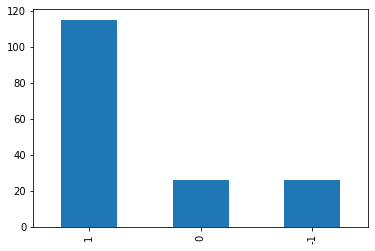

In [8]:
train['label'].value_counts().plot(kind='bar')

In [18]:
train.content

0      [[톡톡 이상품] 한빛코리아 / 다지워 네이처 클렌징 솝]//[\n마스카라까지 지우...
1      [[격동의 유통가④]편의점 성장 정체…미래는 근거리 쇼핑]//["파괴적 커머스 시대...
2      [株머니 매니저의 HOT종목]//[\n\n\n\n\n 씨에스윈드는 풍력발전기를 구성...
3      [김민수 더맘마 대표 "동네마트와 '상생'이 경쟁력…30분 총알배송 목표"]//[\...
4      ["카카오 보고있나"…진격의 네이버페이, 中 최대 직구몰 손잡았다]//[[주간투자동...
                             ...                        
159    [새 개편안 첫 타자는…컬리? CJ올리브영?]//[대기업도 백기든 새벽배송…'마켓컬...
160    [승자 없는 새벽배송 전쟁, 그 결말은?]//[\n투자비↑·매출↓ 롯데온·헬로네이처...
161    ['빅딜' 쓸어담는 NH투자증권, SK에코플랜트 주관사 낙점]//[“대주주 사익추구...
163    [“500억 투자했는데”... 홍정국의 아픈 손가락 ‘헬로네이처’ 매각 적신호]//...
164    [오아시스마켓 "오프라인 매장 간판서 '생협' 제외"]//[[고고IPO] ‘업계 4...
Name: content, Length: 133, dtype: object

In [19]:
train.label

0      0
1      1
2      1
3      0
4      1
      ..
159   -1
160   -1
161    0
163    1
164    1
Name: label, Length: 133, dtype: int64

### 토큰화 및 TF-IDF(Term Frequency-Inverse Document Frequency) 벡터화

### 감성 분석 모델 구축

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline


def get_pipe(model, model_name: str) -> Pipeline:
    "TfidfVectorizer와 모델을 연결한 파이프라인을 반환하는 함수"
    tfidf = TfidfVectorizer(analyzer="char", ngram_range=(1, 3))
    pipe = Pipeline([
        ("tfidf", tfidf),
        (model_name, model)
    ])
    return pipe

# 그냥 train 데이터를 tfidf로 fit_transform한 데이터를 만듭시다...

In [21]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

def return_kfold_accuarcy(model, k: int = 5) -> float:
    global train
    "모델을 입력받아 KFold 예측 후 accuracy score를 반환하는 함수"
    kfold = StratifiedKFold(k, shuffle=True, random_state=42)
    result = []
    for train_idx, test_idx in kfold.split(train["content"], train["label"]):
        train, val = train.iloc[train_idx], train.iloc[test_idx]
        model.fit(train["content"], train["label"])
        pred = model.predict(val["content"])
        acc = accuracy_score(val["label"], pred)
        result.append(acc)

    return np.mean(result)

In [22]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC


models = [
    ("naive_bayes", BernoulliNB()),
    ("SGD", SGDClassifier(random_state=42, n_jobs=-1)),
    ("rfc", RandomForestClassifier(random_state=42, n_jobs=-1)),
    ("SVC", SVC(random_state=42)),
    ("ada", AdaBoostClassifier(random_state=42))
]

model_pipes = [(name, get_pipe(model, name)) for name, model in models]

In [13]:
train['label'] = train['label'].astype(int)

/var/folders/1d/lfkpl6ps02xgh0rdprtbmgvw0000gn/T/ipykernel_5204/666466968.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['label'] = train['label'].astype(int)


In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133 entries, 0 to 164
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     133 non-null    object
 1   content  133 non-null    object
 2   label    133 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 4.2+ KB


In [24]:
import rich  # 출력을 이쁘게 꾸며주는 라이브러리
from tqdm.auto import tqdm  # 진행바 라이브러리
from rich.table import Table

table = Table(title="Model Comparison Table")
table.add_column("Model Name", justify="left", style="green")
table.add_column("Accuracy", justify="right")

for model_name, model in tqdm(model_pipes, leave=False):
    acc = return_kfold_accuarcy(model)
    table.add_row(model_name, f"{acc:0.3f}")

rich.print(table)

  0%|          | 0/5 [00:00<?, ?it/s]

IndexError: positional indexers are out-of-bounds

In [ ]:
models = [
    ("naive_bayes", BernoulliNB()),
    ("SGD", SGDClassifier(random_state=42, n_jobs=-1)),
    ("rfc", RandomForestClassifier(random_state=42, n_jobs=-1)),
    ("SVC", SVC(random_state=42)),
    ("ada", AdaBoostClassifier(random_state=42)),
    ("lgbm", LGBMClassifier(random_state=42)),
    ("lgbm2", LGBMClassifier(n_estimators=80, random_state=42)),
    ("xgb", XGBClassifier(random_state=42)),
    ("knc1", KNeighborsClassifier()),
    ("knc2", KNeighborsClassifier(n_neighbors=4))
]

model_pipes = [(name, get_pipe(model, name)) for name, model in models]

In [ ]:
table = Table(title="Model Comparison Table")
table.add_column("Model Name", justify="left", style="green")
table.add_column("Accuracy", justify="right")

for model_name, model in tqdm(model_pipes, leave=False):
    acc = return_kfold_accuarcy(model)
    table.add_row(model_name, f"{acc:0.3f}")

rich.print(table)